## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['rise.css',
 'CoronaVirusEcu.ipynb',
 '.gitignore',
 'environment.yml',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'README.md',
 'images',
 '.git',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

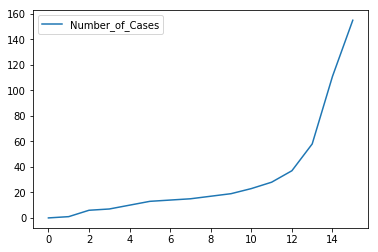

In [4]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = np.array(df['Number_of_Cases'].values.tolist())
y

array([  0,   1,   6,   7,  10,  13,  14,  15,  17,  19,  23,  28,  37,
        58, 111, 155])

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Date'])
x

array([58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [10]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.45057581e+00, 1.05233526e+02, 1.55915121e+07])

In [11]:
(a_, b_, c_) = popt

Matriz Covariante

In [12]:
np.diag(pcov)

array([6.07977997e-01, 1.98254645e+10, 7.98377306e+23])

Error standard para cada parámetro:

In [13]:
np.sqrt(np.diag(pcov))

array([7.79729438e-01, 1.40802928e+05, 8.93519617e+11])

El error del parámetro $c$ es muy elevado:

In [14]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.77972943814088,
 'b_err': 140802.9278413902,
 'c_err': 893519617061.2937}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [15]:
y_pred = logistic_model(x, *popt)
y_pred

array([6.63890577e-02, 9.98430652e-02, 1.50154830e-01, 2.25819118e-01,
       5.10744270e-01, 7.68112615e-01, 1.15517103e+00, 2.61269704e+00,
       5.90924186e+00, 1.33651662e+01, 2.00999778e+01, 3.02285069e+01,
       4.54608629e+01, 6.83688758e+01, 1.02820304e+02, 1.54631810e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

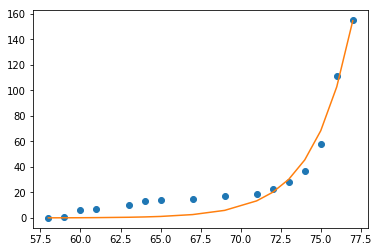

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [17]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en millones):

In [18]:
results['total_infected']/1e6

15.591512116535618

In [19]:
results['total_infected']-errors_dict['c_err']

-893504025549.1771

El pico de infección se obtiene para el día:

In [20]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

151

La fecha esperada para el pico de infección es:

In [21]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 31


Cuántos casos se espera para hoy?

In [22]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-22 00:00:00 corresponde al día 81 con respecto al 01/01/20
Predicción del número de infecciones: 790.9822238290434


Para la fecha de máxima infecciones, cuántas infecciones?

In [23]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)/1e6
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 15.591511995729325


## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

In [24]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 4, 13)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)/1e6

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

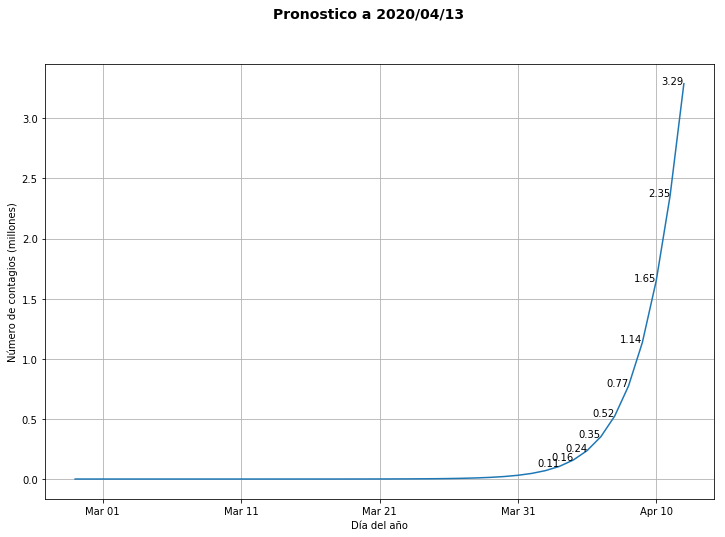

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Pronostico a 2020/04/13', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
for xi,yi in zip(x_pronos,y_pronos):
    if yi>0.1:
        ax.text(xi-0.8, yi, "%.2f" %yi, ha='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios (millones)')
ax.grid(True)
fig.savefig('images/proyectionApril13.png')

<center>
<img src="images/proyectionApril13.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Si consideramos que la población del Ecuador es de 17 millones (https://countrymeters.info/es/Ecuador), 15 millones de contagiados, en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.

* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 


In [26]:
population = 17368483
rate = results['total_infected']/population*100.0
print(rate)
days_remaining = sol-df['Date'].iloc[0]
print(days_remaining)

89.76899201004267
93


### Artificial Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [28]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)  

In [29]:
x_stats = df["Date"].describe()
x_stats

count    16.000000
mean     67.750000
std       6.454972
min      58.000000
25%      62.500000
50%      68.000000
75%      73.250000
max      77.000000
Name: Date, dtype: float64

In [30]:
y_stats = df["Number_of_Cases"].describe()
y_stats

count     16.000000
mean      32.125000
std       42.665951
min        0.000000
25%        9.250000
50%       16.000000
75%       30.250000
max      155.000000
Name: Number_of_Cases, dtype: float64

In [31]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.51046351, -1.35554417, -1.20062484, -1.0457055 , -0.73586684,
       -0.5809475 , -0.42602817, -0.1161895 ,  0.19364917,  0.50348784,
        0.65840717,  0.8133265 ,  0.96824584,  1.12316517,  1.2780845 ,
        1.43300384])

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14/14 [==============================] - 1s 62ms/step - loss: 3125.3181 - mean_absolute_error: 36.5878 - mean_squared_error: 3125.3181
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3112.4906 - mean_absolute_error: 36.4745 - mean_squared_error: 3112.4906
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3100.3496 - mean_absolute_error: 36.3424 - mean_squared_error: 3100.3496
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 3085.6976 - mean_absolute_error: 36.1954 - mean_squared_error: 3085.6976
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 3070.4977 - mean_absolute_error: 35.9966 - mean_squared_error: 3070.4977
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 3047.5428 - mean_absolute_error: 35.7484 - mean_squared_error: 3047.5428
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 30

14/14 [==============================] - 0s 3ms/step - loss: 560.5088 - mean_absolute_error: 17.4371 - mean_squared_error: 560.5088
Epoch 56/100
14/14 [==============================] - 0s 3ms/step - loss: 586.0285 - mean_absolute_error: 17.6213 - mean_squared_error: 586.0285
Epoch 57/100
14/14 [==============================] - 0s 3ms/step - loss: 598.5105 - mean_absolute_error: 17.9336 - mean_squared_error: 598.5105
Epoch 58/100
14/14 [==============================] - 0s 3ms/step - loss: 583.5291 - mean_absolute_error: 18.0616 - mean_squared_error: 583.5291
Epoch 59/100
14/14 [==============================] - 0s 3ms/step - loss: 510.2430 - mean_absolute_error: 16.9105 - mean_squared_error: 510.2430
Epoch 60/100
14/14 [==============================] - 0s 3ms/step - loss: 511.5570 - mean_absolute_error: 16.7682 - mean_squared_error: 511.5570
Epoch 61/100
14/14 [==============================] - 0s 3ms/step - loss: 570.6506 - mean_absolute_error: 17.3669 - mean_squared_error: 570.650

14/14 [==============================] - 0s 3ms/step - loss: 2836.0325 - mean_absolute_error: 33.7365 - mean_squared_error: 2836.0325
Epoch 12/100
14/14 [==============================] - 0s 3ms/step - loss: 2779.2840 - mean_absolute_error: 33.3593 - mean_squared_error: 2779.2840
Epoch 13/100
14/14 [==============================] - 0s 3ms/step - loss: 2719.0606 - mean_absolute_error: 32.9118 - mean_squared_error: 2719.0606
Epoch 14/100
14/14 [==============================] - 0s 3ms/step - loss: 2660.1898 - mean_absolute_error: 32.5433 - mean_squared_error: 2660.1898
Epoch 15/100
14/14 [==============================] - 0s 3ms/step - loss: 2557.5231 - mean_absolute_error: 31.6645 - mean_squared_error: 2557.5231
Epoch 16/100
14/14 [==============================] - 0s 3ms/step - loss: 2466.3382 - mean_absolute_error: 30.8311 - mean_squared_error: 2466.3382
Epoch 17/100
14/14 [==============================] - 0s 3ms/step - loss: 2363.7259 - mean_absolute_error: 29.9744 - mean_squared_e

14/14 [==============================] - 0s 3ms/step - loss: 571.3290 - mean_absolute_error: 18.4025 - mean_squared_error: 571.3290
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 606.8449 - mean_absolute_error: 18.3132 - mean_squared_error: 606.8449
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 496.0911 - mean_absolute_error: 16.7557 - mean_squared_error: 496.0911
Epoch 70/100
14/14 [==============================] - 0s 3ms/step - loss: 530.3738 - mean_absolute_error: 17.5147 - mean_squared_error: 530.3738
Epoch 71/100
14/14 [==============================] - 0s 3ms/step - loss: 652.0388 - mean_absolute_error: 19.2003 - mean_squared_error: 652.0388
Epoch 72/100
14/14 [==============================] - 0s 3ms/step - loss: 567.5668 - mean_absolute_error: 17.5079 - mean_squared_error: 567.5668
Epoch 73/100
14/14 [==============================] - 0s 3ms/step - loss: 527.2441 - mean_absolute_error: 17.5834 - mean_squared_error: 527.244

Epoch 23/100
14/14 [==============================] - 0s 3ms/step - loss: 1652.5839 - mean_absolute_error: 22.6348 - mean_squared_error: 1652.5839
Epoch 24/100
14/14 [==============================] - 0s 3ms/step - loss: 1538.4077 - mean_absolute_error: 20.9656 - mean_squared_error: 1538.4077
Epoch 25/100
14/14 [==============================] - 0s 3ms/step - loss: 1353.6134 - mean_absolute_error: 18.7512 - mean_squared_error: 1353.6134
Epoch 26/100
14/14 [==============================] - 0s 3ms/step - loss: 1251.9017 - mean_absolute_error: 17.8797 - mean_squared_error: 1251.9017
Epoch 27/100
14/14 [==============================] - 0s 3ms/step - loss: 1165.7549 - mean_absolute_error: 17.5211 - mean_squared_error: 1165.7549
Epoch 28/100
14/14 [==============================] - 0s 3ms/step - loss: 963.0222 - mean_absolute_error: 17.1268 - mean_squared_error: 963.0222
Epoch 29/100
14/14 [==============================] - 0s 3ms/step - loss: 911.6647 - mean_absolute_error: 16.5465 - mean

14/14 [==============================] - 0s 3ms/step - loss: 525.2548 - mean_absolute_error: 17.4766 - mean_squared_error: 525.2548
Epoch 80/100
14/14 [==============================] - 0s 3ms/step - loss: 519.0298 - mean_absolute_error: 16.8631 - mean_squared_error: 519.0298
Epoch 81/100
14/14 [==============================] - 0s 3ms/step - loss: 575.2671 - mean_absolute_error: 17.7091 - mean_squared_error: 575.2671
Epoch 82/100
14/14 [==============================] - 0s 3ms/step - loss: 643.6738 - mean_absolute_error: 18.1461 - mean_squared_error: 643.6738
Epoch 83/100
14/14 [==============================] - 0s 3ms/step - loss: 479.5823 - mean_absolute_error: 16.4437 - mean_squared_error: 479.5823
Epoch 84/100
14/14 [==============================] - 0s 3ms/step - loss: 557.8076 - mean_absolute_error: 16.8595 - mean_squared_error: 557.8076
Epoch 85/100
14/14 [==============================] - 0s 3ms/step - loss: 507.8253 - mean_absolute_error: 16.9060 - mean_squared_error: 507.825

14/14 [==============================] - 0s 3ms/step - loss: 659.6104 - mean_absolute_error: 17.3972 - mean_squared_error: 659.6104
Epoch 35/100
14/14 [==============================] - 0s 3ms/step - loss: 577.8938 - mean_absolute_error: 17.3090 - mean_squared_error: 577.8938
Epoch 36/100
14/14 [==============================] - 0s 3ms/step - loss: 523.9129 - mean_absolute_error: 16.3360 - mean_squared_error: 523.9129
Epoch 37/100
14/14 [==============================] - 0s 3ms/step - loss: 630.0097 - mean_absolute_error: 18.4804 - mean_squared_error: 630.0097
Epoch 38/100
14/14 [==============================] - 0s 3ms/step - loss: 610.8030 - mean_absolute_error: 17.6171 - mean_squared_error: 610.8030
Epoch 39/100
14/14 [==============================] - 0s 3ms/step - loss: 593.9843 - mean_absolute_error: 17.8841 - mean_squared_error: 593.9843
Epoch 40/100
14/14 [==============================] - 0s 3ms/step - loss: 568.2492 - mean_absolute_error: 17.5646 - mean_squared_error: 568.249

14/14 [==============================] - 0s 3ms/step - loss: 444.4787 - mean_absolute_error: 15.5443 - mean_squared_error: 444.4787
Epoch 91/100
14/14 [==============================] - 0s 3ms/step - loss: 557.5332 - mean_absolute_error: 17.7270 - mean_squared_error: 557.5332
Epoch 92/100
14/14 [==============================] - 0s 3ms/step - loss: 543.6973 - mean_absolute_error: 17.5828 - mean_squared_error: 543.6973
Epoch 93/100
14/14 [==============================] - 0s 3ms/step - loss: 620.9628 - mean_absolute_error: 18.2695 - mean_squared_error: 620.9628
Epoch 94/100
14/14 [==============================] - 0s 3ms/step - loss: 609.7964 - mean_absolute_error: 17.6821 - mean_squared_error: 609.7964
Epoch 95/100
14/14 [==============================] - 0s 3ms/step - loss: 546.1777 - mean_absolute_error: 16.9796 - mean_squared_error: 546.1777
Epoch 96/100
14/14 [==============================] - 0s 3ms/step - loss: 509.5149 - mean_absolute_error: 16.9190 - mean_squared_error: 509.514

14/14 [==============================] - 0s 3ms/step - loss: 621.2894 - mean_absolute_error: 17.6264 - mean_squared_error: 621.2894
Epoch 46/100
14/14 [==============================] - 0s 3ms/step - loss: 666.9351 - mean_absolute_error: 18.0451 - mean_squared_error: 666.9351
Epoch 47/100
14/14 [==============================] - 0s 3ms/step - loss: 575.9850 - mean_absolute_error: 17.3534 - mean_squared_error: 575.9850
Epoch 48/100
14/14 [==============================] - 0s 3ms/step - loss: 599.4069 - mean_absolute_error: 17.6160 - mean_squared_error: 599.4069
Epoch 49/100
14/14 [==============================] - 0s 3ms/step - loss: 532.4092 - mean_absolute_error: 16.8637 - mean_squared_error: 532.4092
Epoch 50/100
14/14 [==============================] - 0s 3ms/step - loss: 532.3837 - mean_absolute_error: 16.8039 - mean_squared_error: 532.3837
Epoch 51/100
14/14 [==============================] - 0s 3ms/step - loss: 627.8927 - mean_absolute_error: 18.1322 - mean_squared_error: 627.892

14/14 [==============================] - 0s 33ms/step - loss: 3030.1489 - mean_absolute_error: 33.0310 - mean_squared_error: 3030.1489
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3019.7520 - mean_absolute_error: 32.8921 - mean_squared_error: 3019.7520
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3008.7268 - mean_absolute_error: 32.7640 - mean_squared_error: 3008.7268
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 2996.3548 - mean_absolute_error: 32.6374 - mean_squared_error: 2996.3548
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2977.4825 - mean_absolute_error: 32.5002 - mean_squared_error: 2977.4825
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 2958.0711 - mean_absolute_error: 32.3171 - mean_squared_error: 2958.0711
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 2926.7642 - mean_absolute_error: 32.0121 - mean_squared_error:

14/14 [==============================] - 0s 3ms/step - loss: 486.8207 - mean_absolute_error: 14.3256 - mean_squared_error: 486.8207
Epoch 58/100
14/14 [==============================] - 0s 3ms/step - loss: 445.0710 - mean_absolute_error: 14.4171 - mean_squared_error: 445.0710
Epoch 59/100
14/14 [==============================] - 0s 3ms/step - loss: 361.2539 - mean_absolute_error: 12.8632 - mean_squared_error: 361.2539
Epoch 60/100
14/14 [==============================] - 0s 3ms/step - loss: 442.5598 - mean_absolute_error: 14.6178 - mean_squared_error: 442.5598
Epoch 61/100
14/14 [==============================] - 0s 3ms/step - loss: 487.1228 - mean_absolute_error: 14.8469 - mean_squared_error: 487.1228
Epoch 62/100
14/14 [==============================] - 0s 3ms/step - loss: 532.2647 - mean_absolute_error: 15.6107 - mean_squared_error: 532.2647
Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 446.4493 - mean_absolute_error: 14.2735 - mean_squared_error: 446.449

15/15 [==============================] - 0s 3ms/step - loss: 2556.2311 - mean_absolute_error: 29.4497 - mean_squared_error: 2556.2311
Epoch 14/100
15/15 [==============================] - 0s 3ms/step - loss: 2505.9842 - mean_absolute_error: 28.8918 - mean_squared_error: 2505.9842
Epoch 15/100
15/15 [==============================] - 0s 3ms/step - loss: 2436.4154 - mean_absolute_error: 28.6277 - mean_squared_error: 2436.4154
Epoch 16/100
15/15 [==============================] - 0s 3ms/step - loss: 2371.9077 - mean_absolute_error: 28.0574 - mean_squared_error: 2371.9077
Epoch 17/100
15/15 [==============================] - 0s 3ms/step - loss: 2288.3746 - mean_absolute_error: 27.5153 - mean_squared_error: 2288.3746
Epoch 18/100
15/15 [==============================] - 0s 3ms/step - loss: 2197.6551 - mean_absolute_error: 26.7419 - mean_squared_error: 2197.6551
Epoch 19/100
15/15 [==============================] - 0s 3ms/step - loss: 2087.5407 - mean_absolute_error: 26.1201 - mean_squared_e

15/15 [==============================] - 0s 3ms/step - loss: 433.2669 - mean_absolute_error: 14.7949 - mean_squared_error: 433.2669
Epoch 70/100
15/15 [==============================] - 0s 3ms/step - loss: 537.5374 - mean_absolute_error: 15.9596 - mean_squared_error: 537.5374
Epoch 71/100
15/15 [==============================] - 0s 3ms/step - loss: 417.6337 - mean_absolute_error: 14.6799 - mean_squared_error: 417.6337
Epoch 72/100
15/15 [==============================] - 0s 3ms/step - loss: 390.9178 - mean_absolute_error: 13.9684 - mean_squared_error: 390.9178
Epoch 73/100
15/15 [==============================] - 0s 3ms/step - loss: 450.9335 - mean_absolute_error: 15.2195 - mean_squared_error: 450.9335
Epoch 74/100
15/15 [==============================] - 0s 3ms/step - loss: 527.6752 - mean_absolute_error: 16.1476 - mean_squared_error: 527.6752
Epoch 75/100
15/15 [==============================] - 0s 3ms/step - loss: 496.6303 - mean_absolute_error: 15.6602 - mean_squared_error: 496.630

15/15 [==============================] - 0s 3ms/step - loss: 1170.2020 - mean_absolute_error: 16.9023 - mean_squared_error: 1170.2020
Epoch 25/100
15/15 [==============================] - 0s 3ms/step - loss: 1010.6063 - mean_absolute_error: 15.8268 - mean_squared_error: 1010.6063
Epoch 26/100
15/15 [==============================] - 0s 3ms/step - loss: 949.4280 - mean_absolute_error: 16.0918 - mean_squared_error: 949.4280
Epoch 27/100
15/15 [==============================] - 0s 3ms/step - loss: 807.3271 - mean_absolute_error: 15.6493 - mean_squared_error: 807.3271
Epoch 28/100
15/15 [==============================] - 0s 3ms/step - loss: 716.1416 - mean_absolute_error: 16.3545 - mean_squared_error: 716.1416
Epoch 29/100
15/15 [==============================] - 0s 3ms/step - loss: 689.9308 - mean_absolute_error: 16.0858 - mean_squared_error: 689.9308
Epoch 30/100
15/15 [==============================] - 0s 3ms/step - loss: 747.9889 - mean_absolute_error: 17.5959 - mean_squared_error: 747

15/15 [==============================] - 0s 3ms/step - loss: 523.3347 - mean_absolute_error: 15.6830 - mean_squared_error: 523.3347
Epoch 81/100
15/15 [==============================] - 0s 3ms/step - loss: 422.3422 - mean_absolute_error: 14.7218 - mean_squared_error: 422.3422
Epoch 82/100
15/15 [==============================] - 0s 3ms/step - loss: 492.6146 - mean_absolute_error: 15.4046 - mean_squared_error: 492.6146
Epoch 83/100
15/15 [==============================] - 0s 3ms/step - loss: 444.0968 - mean_absolute_error: 14.9303 - mean_squared_error: 444.0968
Epoch 84/100
15/15 [==============================] - 0s 3ms/step - loss: 500.7164 - mean_absolute_error: 15.4641 - mean_squared_error: 500.7164
Epoch 85/100
15/15 [==============================] - 0s 3ms/step - loss: 599.7562 - mean_absolute_error: 16.9700 - mean_squared_error: 599.7562
Epoch 86/100
15/15 [==============================] - 0s 3ms/step - loss: 455.3281 - mean_absolute_error: 15.0555 - mean_squared_error: 455.328

15/15 [==============================] - 0s 3ms/step - loss: 568.3495 - mean_absolute_error: 13.1685 - mean_squared_error: 568.3495
Epoch 36/100
15/15 [==============================] - 0s 3ms/step - loss: 554.7062 - mean_absolute_error: 12.8187 - mean_squared_error: 554.7062
Epoch 37/100
15/15 [==============================] - 0s 3ms/step - loss: 531.1961 - mean_absolute_error: 12.8878 - mean_squared_error: 531.1961
Epoch 38/100
15/15 [==============================] - 0s 3ms/step - loss: 503.0942 - mean_absolute_error: 13.3360 - mean_squared_error: 503.0942
Epoch 39/100
15/15 [==============================] - 0s 3ms/step - loss: 532.5209 - mean_absolute_error: 14.0698 - mean_squared_error: 532.5209
Epoch 40/100
15/15 [==============================] - 0s 3ms/step - loss: 560.2611 - mean_absolute_error: 15.0283 - mean_squared_error: 560.2611
Epoch 41/100
15/15 [==============================] - 0s 3ms/step - loss: 488.1661 - mean_absolute_error: 14.0586 - mean_squared_error: 488.166

15/15 [==============================] - 0s 3ms/step - loss: 542.0468 - mean_absolute_error: 14.6562 - mean_squared_error: 542.0468
Epoch 92/100
15/15 [==============================] - 0s 3ms/step - loss: 465.9731 - mean_absolute_error: 13.7768 - mean_squared_error: 465.9731
Epoch 93/100
15/15 [==============================] - 0s 3ms/step - loss: 459.3979 - mean_absolute_error: 13.4390 - mean_squared_error: 459.3979
Epoch 94/100
15/15 [==============================] - 0s 3ms/step - loss: 463.7710 - mean_absolute_error: 14.0351 - mean_squared_error: 463.7710
Epoch 95/100
15/15 [==============================] - 0s 3ms/step - loss: 431.8676 - mean_absolute_error: 12.8916 - mean_squared_error: 431.8676
Epoch 96/100
15/15 [==============================] - 0s 3ms/step - loss: 507.8794 - mean_absolute_error: 14.0537 - mean_squared_error: 507.8794
Epoch 97/100
15/15 [==============================] - 0s 3ms/step - loss: 454.9121 - mean_absolute_error: 13.2697 - mean_squared_error: 454.912

15/15 [==============================] - 0s 3ms/step - loss: 200.3894 - mean_absolute_error: 9.7049 - mean_squared_error: 200.3894
Epoch 48/100
15/15 [==============================] - 0s 3ms/step - loss: 241.5420 - mean_absolute_error: 10.5691 - mean_squared_error: 241.5420
Epoch 49/100
15/15 [==============================] - 0s 3ms/step - loss: 207.8863 - mean_absolute_error: 10.0189 - mean_squared_error: 207.8863
Epoch 50/100
15/15 [==============================] - 0s 3ms/step - loss: 201.1901 - mean_absolute_error: 10.5147 - mean_squared_error: 201.1901
Epoch 51/100
15/15 [==============================] - 0s 3ms/step - loss: 248.1046 - mean_absolute_error: 10.7406 - mean_squared_error: 248.1046
Epoch 52/100
15/15 [==============================] - 0s 3ms/step - loss: 257.7045 - mean_absolute_error: 10.4707 - mean_squared_error: 257.7045
Epoch 53/100
15/15 [==============================] - 0s 3ms/step - loss: 239.1070 - mean_absolute_error: 11.2150 - mean_squared_error: 239.1070

In [33]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[ 0.0091165 ],
       [ 0.00818145],
       [ 0.00724644],
       [ 0.00631142],
       [ 0.00444137],
       [ 0.00350634],
       [ 0.00257131],
       [ 0.00070127],
       [-0.00784274],
       [-0.02039112],
       [-0.02666533],
       [-0.03293954],
       [-0.03921369],
       [-0.0454879 ],
       [-0.05176208],
       [-0.0580363 ]], dtype=float32)

In [34]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [35]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
16/16 [==============================] - 1s 59ms/step - loss: 2741.2061 - mean_absolute_error: 32.1410 - mean_squared_error: 2741.2061
Epoch 2/1500
16/16 [==============================] - 0s 1ms/step - loss: 2735.0942 - mean_absolute_error: 32.0836 - mean_squared_error: 2735.0942
Epoch 3/1500
16/16 [==============================] - 0s 1ms/step - loss: 2731.3027 - mean_absolute_error: 32.0501 - mean_squared_error: 2731.3027
Epoch 4/1500
16/16 [==============================] - 0s 1ms/step - loss: 2726.9270 - mean_absolute_error: 32.0003 - mean_squared_error: 2726.9270
Epoch 5/1500
16/16 [==============================] - 0s 997us/step - loss: 2721.9873 - mean_absolute_error: 31.9593 - mean_squared_error: 2721.9873
Epoch 6/1500
16/16 [==============================] - 0s 1ms/step - loss: 2717.3557 - mean_absolute_error: 31.9092 - mean_squared_error: 2717.3557
Epoch 7/1500
16/16 [==============================] - 0s 1ms/step - loss: 2711.3882 - mean_absolute_error: 31.8565 

Epoch 57/1500
16/16 [==============================] - 0s 2ms/step - loss: 648.1716 - mean_absolute_error: 14.8832 - mean_squared_error: 648.1716
Epoch 58/1500
16/16 [==============================] - 0s 1ms/step - loss: 646.3550 - mean_absolute_error: 14.5791 - mean_squared_error: 646.3550
Epoch 59/1500
16/16 [==============================] - 0s 1ms/step - loss: 614.5698 - mean_absolute_error: 14.7091 - mean_squared_error: 614.5698
Epoch 60/1500
16/16 [==============================] - 0s 1ms/step - loss: 619.9661 - mean_absolute_error: 15.0842 - mean_squared_error: 619.9661
Epoch 61/1500
16/16 [==============================] - 0s 1ms/step - loss: 632.0699 - mean_absolute_error: 15.2954 - mean_squared_error: 632.0699
Epoch 62/1500
16/16 [==============================] - 0s 1ms/step - loss: 563.9603 - mean_absolute_error: 14.9827 - mean_squared_error: 563.9603
Epoch 63/1500
16/16 [==============================] - 0s 1ms/step - loss: 530.4313 - mean_absolute_error: 15.1247 - mean_sq

Epoch 113/1500
16/16 [==============================] - 0s 980us/step - loss: 438.6107 - mean_absolute_error: 15.0843 - mean_squared_error: 438.6107
Epoch 114/1500
16/16 [==============================] - 0s 986us/step - loss: 423.9934 - mean_absolute_error: 14.5884 - mean_squared_error: 423.9934
Epoch 115/1500
16/16 [==============================] - 0s 1ms/step - loss: 453.3858 - mean_absolute_error: 15.3492 - mean_squared_error: 453.3858
Epoch 116/1500
16/16 [==============================] - 0s 1ms/step - loss: 402.4556 - mean_absolute_error: 14.5607 - mean_squared_error: 402.4556
Epoch 117/1500
16/16 [==============================] - 0s 1ms/step - loss: 408.7122 - mean_absolute_error: 14.6451 - mean_squared_error: 408.7122
Epoch 118/1500
16/16 [==============================] - 0s 1ms/step - loss: 457.3233 - mean_absolute_error: 15.0385 - mean_squared_error: 457.3233
Epoch 119/1500
16/16 [==============================] - 0s 1ms/step - loss: 456.5300 - mean_absolute_error: 14.845

Epoch 169/1500
16/16 [==============================] - 0s 1ms/step - loss: 343.0016 - mean_absolute_error: 12.5509 - mean_squared_error: 343.0016
Epoch 170/1500
16/16 [==============================] - 0s 1ms/step - loss: 383.9960 - mean_absolute_error: 13.2224 - mean_squared_error: 383.9960
Epoch 171/1500
16/16 [==============================] - 0s 1ms/step - loss: 351.8412 - mean_absolute_error: 12.3776 - mean_squared_error: 351.8412
Epoch 172/1500
16/16 [==============================] - 0s 1ms/step - loss: 357.4990 - mean_absolute_error: 12.7159 - mean_squared_error: 357.4990
Epoch 173/1500
16/16 [==============================] - 0s 1ms/step - loss: 404.5309 - mean_absolute_error: 13.7142 - mean_squared_error: 404.5309
Epoch 174/1500
16/16 [==============================] - 0s 984us/step - loss: 382.7953 - mean_absolute_error: 12.5662 - mean_squared_error: 382.7953
Epoch 175/1500
16/16 [==============================] - 0s 1ms/step - loss: 400.2137 - mean_absolute_error: 12.9246 

Epoch 225/1500
16/16 [==============================] - 0s 962us/step - loss: 293.7557 - mean_absolute_error: 11.1732 - mean_squared_error: 293.7557
Epoch 226/1500
16/16 [==============================] - 0s 1ms/step - loss: 313.7552 - mean_absolute_error: 11.3220 - mean_squared_error: 313.7552
Epoch 227/1500
16/16 [==============================] - 0s 1ms/step - loss: 283.8256 - mean_absolute_error: 11.1656 - mean_squared_error: 283.8256
Epoch 228/1500
16/16 [==============================] - 0s 997us/step - loss: 323.6160 - mean_absolute_error: 11.7786 - mean_squared_error: 323.6160
Epoch 229/1500
16/16 [==============================] - 0s 1ms/step - loss: 265.9208 - mean_absolute_error: 10.7582 - mean_squared_error: 265.9208
Epoch 230/1500
16/16 [==============================] - 0s 1ms/step - loss: 343.4479 - mean_absolute_error: 11.5284 - mean_squared_error: 343.4479
Epoch 231/1500
16/16 [==============================] - 0s 1ms/step - loss: 315.9198 - mean_absolute_error: 11.280

Epoch 281/1500
16/16 [==============================] - 0s 1ms/step - loss: 240.5623 - mean_absolute_error: 9.5885 - mean_squared_error: 240.5623
Epoch 282/1500
16/16 [==============================] - 0s 1ms/step - loss: 256.4015 - mean_absolute_error: 10.0801 - mean_squared_error: 256.4015
Epoch 283/1500
16/16 [==============================] - 0s 1ms/step - loss: 280.3701 - mean_absolute_error: 10.6115 - mean_squared_error: 280.3701
Epoch 284/1500
16/16 [==============================] - 0s 1ms/step - loss: 226.0180 - mean_absolute_error: 9.7289 - mean_squared_error: 226.0180
Epoch 285/1500
16/16 [==============================] - 0s 1ms/step - loss: 255.5282 - mean_absolute_error: 9.7812 - mean_squared_error: 255.5282
Epoch 286/1500
16/16 [==============================] - 0s 1ms/step - loss: 270.0811 - mean_absolute_error: 10.2162 - mean_squared_error: 270.0811
Epoch 287/1500
16/16 [==============================] - 0s 1ms/step - loss: 295.3438 - mean_absolute_error: 10.9392 - mea

Epoch 337/1500
16/16 [==============================] - 0s 920us/step - loss: 146.1311 - mean_absolute_error: 7.1762 - mean_squared_error: 146.1311
Epoch 338/1500
16/16 [==============================] - 0s 956us/step - loss: 136.9356 - mean_absolute_error: 7.3487 - mean_squared_error: 136.9356
Epoch 339/1500
16/16 [==============================] - 0s 1ms/step - loss: 120.5913 - mean_absolute_error: 6.8635 - mean_squared_error: 120.5913
Epoch 340/1500
16/16 [==============================] - 0s 1ms/step - loss: 167.2623 - mean_absolute_error: 8.0006 - mean_squared_error: 167.2623
Epoch 341/1500
16/16 [==============================] - 0s 1ms/step - loss: 137.4415 - mean_absolute_error: 7.0432 - mean_squared_error: 137.4415
Epoch 342/1500
16/16 [==============================] - 0s 1ms/step - loss: 156.7286 - mean_absolute_error: 7.6627 - mean_squared_error: 156.7286
Epoch 343/1500
16/16 [==============================] - 0s 1ms/step - loss: 127.2103 - mean_absolute_error: 7.0625 - mea

Epoch 394/1500
16/16 [==============================] - 0s 1ms/step - loss: 53.1139 - mean_absolute_error: 4.2740 - mean_squared_error: 53.1139
Epoch 395/1500
16/16 [==============================] - 0s 1ms/step - loss: 60.1461 - mean_absolute_error: 4.7054 - mean_squared_error: 60.1461
Epoch 396/1500
16/16 [==============================] - 0s 1ms/step - loss: 67.3617 - mean_absolute_error: 4.5660 - mean_squared_error: 67.3617
Epoch 397/1500
16/16 [==============================] - 0s 1ms/step - loss: 35.4027 - mean_absolute_error: 3.6384 - mean_squared_error: 35.4027
Epoch 398/1500
16/16 [==============================] - 0s 986us/step - loss: 36.6149 - mean_absolute_error: 3.6359 - mean_squared_error: 36.6149
Epoch 399/1500
16/16 [==============================] - 0s 1ms/step - loss: 55.3095 - mean_absolute_error: 4.8007 - mean_squared_error: 55.3095
Epoch 400/1500
16/16 [==============================] - 0s 1ms/step - loss: 70.7645 - mean_absolute_error: 5.3077 - mean_squared_error

Epoch 451/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.3753 - mean_absolute_error: 2.2362 - mean_squared_error: 17.3753
Epoch 452/1500
16/16 [==============================] - 0s 1ms/step - loss: 28.4911 - mean_absolute_error: 3.2246 - mean_squared_error: 28.4911
Epoch 453/1500
16/16 [==============================] - 0s 1ms/step - loss: 26.2492 - mean_absolute_error: 3.2299 - mean_squared_error: 26.2492
Epoch 454/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.7965 - mean_absolute_error: 2.8580 - mean_squared_error: 17.7965
Epoch 455/1500
16/16 [==============================] - 0s 1ms/step - loss: 25.5940 - mean_absolute_error: 3.1709 - mean_squared_error: 25.5940
Epoch 456/1500
16/16 [==============================] - 0s 1ms/step - loss: 16.8253 - mean_absolute_error: 2.4377 - mean_squared_error: 16.8253
Epoch 457/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.9506 - mean_absolute_error: 2.3159 - mean_squared_error: 

Epoch 508/1500
16/16 [==============================] - 0s 983us/step - loss: 11.7725 - mean_absolute_error: 2.6831 - mean_squared_error: 11.7725
Epoch 509/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.0013 - mean_absolute_error: 2.1840 - mean_squared_error: 11.0013
Epoch 510/1500
16/16 [==============================] - 0s 912us/step - loss: 20.7587 - mean_absolute_error: 3.0919 - mean_squared_error: 20.7587
Epoch 511/1500
16/16 [==============================] - 0s 908us/step - loss: 8.1315 - mean_absolute_error: 2.0828 - mean_squared_error: 8.1315
Epoch 512/1500
16/16 [==============================] - 0s 1ms/step - loss: 19.5588 - mean_absolute_error: 2.2788 - mean_squared_error: 19.5588
Epoch 513/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.3970 - mean_absolute_error: 2.1531 - mean_squared_error: 11.3970
Epoch 514/1500
16/16 [==============================] - 0s 1ms/step - loss: 8.3768 - mean_absolute_error: 1.8337 - mean_squared_erro

Epoch 566/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.7304 - mean_absolute_error: 1.4913 - mean_squared_error: 5.7304
Epoch 567/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.3318 - mean_absolute_error: 1.4476 - mean_squared_error: 4.3318
Epoch 568/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.7977 - mean_absolute_error: 1.5273 - mean_squared_error: 6.7977
Epoch 569/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.5303 - mean_absolute_error: 1.6128 - mean_squared_error: 7.5303
Epoch 570/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.2689 - mean_absolute_error: 1.5049 - mean_squared_error: 5.2689
Epoch 571/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.6806 - mean_absolute_error: 1.4801 - mean_squared_error: 3.6806
Epoch 572/1500
16/16 [==============================] - 0s 978us/step - loss: 8.6180 - mean_absolute_error: 1.7764 - mean_squared_error: 8.6180
Epoc

Epoch 624/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.1404 - mean_absolute_error: 1.2910 - mean_squared_error: 4.1404
Epoch 625/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.5430 - mean_absolute_error: 1.8760 - mean_squared_error: 9.5430
Epoch 626/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.8071 - mean_absolute_error: 1.7879 - mean_squared_error: 4.8071
Epoch 627/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.0829 - mean_absolute_error: 1.8405 - mean_squared_error: 6.0829
Epoch 628/1500
16/16 [==============================] - 0s 1ms/step - loss: 10.7905 - mean_absolute_error: 2.2259 - mean_squared_error: 10.7905
Epoch 629/1500
16/16 [==============================] - 0s 1ms/step - loss: 21.0464 - mean_absolute_error: 2.7362 - mean_squared_error: 21.0464
Epoch 630/1500
16/16 [==============================] - 0s 1ms/step - loss: 18.0854 - mean_absolute_error: 3.0341 - mean_squared_error: 18.0854


Epoch 682/1500
16/16 [==============================] - 0s 976us/step - loss: 2.0129 - mean_absolute_error: 1.2441 - mean_squared_error: 2.0129
Epoch 683/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.7817 - mean_absolute_error: 1.4781 - mean_squared_error: 5.7817
Epoch 684/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.9404 - mean_absolute_error: 1.4927 - mean_squared_error: 4.9404
Epoch 685/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.4092 - mean_absolute_error: 1.2298 - mean_squared_error: 3.4092
Epoch 686/1500
16/16 [==============================] - 0s 1ms/step - loss: 10.1384 - mean_absolute_error: 1.5620 - mean_squared_error: 10.1384
Epoch 687/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.5836 - mean_absolute_error: 1.1112 - mean_squared_error: 2.5836
Epoch 688/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.6644 - mean_absolute_error: 2.4308 - mean_squared_error: 15.6644


Epoch 740/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.3874 - mean_absolute_error: 1.5055 - mean_squared_error: 4.3874
Epoch 741/1500
16/16 [==============================] - 0s 2ms/step - loss: 23.6102 - mean_absolute_error: 2.4337 - mean_squared_error: 23.6102
Epoch 742/1500
16/16 [==============================] - 0s 3ms/step - loss: 14.9883 - mean_absolute_error: 2.6608 - mean_squared_error: 14.9883
Epoch 743/1500
16/16 [==============================] - 0s 2ms/step - loss: 16.6112 - mean_absolute_error: 2.7204 - mean_squared_error: 16.6112
Epoch 744/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.1351 - mean_absolute_error: 2.0866 - mean_squared_error: 7.1351
Epoch 745/1500
16/16 [==============================] - 0s 1ms/step - loss: 10.4254 - mean_absolute_error: 2.3108 - mean_squared_error: 10.4254
Epoch 746/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.2180 - mean_absolute_error: 2.2233 - mean_squared_error: 15.2

Epoch 798/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.4931 - mean_absolute_error: 1.3526 - mean_squared_error: 2.4931
Epoch 799/1500
16/16 [==============================] - 0s 1ms/step - loss: 8.3274 - mean_absolute_error: 1.9359 - mean_squared_error: 8.3274
Epoch 800/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.7012 - mean_absolute_error: 1.8372 - mean_squared_error: 7.7012
Epoch 801/1500
16/16 [==============================] - 0s 2ms/step - loss: 5.5843 - mean_absolute_error: 1.6224 - mean_squared_error: 5.5843
Epoch 802/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.4875 - mean_absolute_error: 1.2681 - mean_squared_error: 2.4875
Epoch 803/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.1986 - mean_absolute_error: 1.7270 - mean_squared_error: 7.1986
Epoch 804/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.5316 - mean_absolute_error: 1.7398 - mean_squared_error: 5.5316
Epoch 

Epoch 856/1500
16/16 [==============================] - 0s 1ms/step - loss: 27.4899 - mean_absolute_error: 3.2517 - mean_squared_error: 27.4899
Epoch 857/1500
16/16 [==============================] - 0s 967us/step - loss: 8.3650 - mean_absolute_error: 2.1786 - mean_squared_error: 8.3650
Epoch 858/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.5543 - mean_absolute_error: 2.0063 - mean_squared_error: 13.5543
Epoch 859/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.1851 - mean_absolute_error: 1.9206 - mean_squared_error: 7.1851
Epoch 860/1500
16/16 [==============================] - 0s 994us/step - loss: 17.8336 - mean_absolute_error: 2.0467 - mean_squared_error: 17.8336
Epoch 861/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.9722 - mean_absolute_error: 2.1715 - mean_squared_error: 11.9722
Epoch 862/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.8736 - mean_absolute_error: 1.2118 - mean_squared_error: 1

Epoch 914/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.1950 - mean_absolute_error: 2.2370 - mean_squared_error: 14.1950
Epoch 915/1500
16/16 [==============================] - 0s 1ms/step - loss: 16.8243 - mean_absolute_error: 2.3868 - mean_squared_error: 16.8243
Epoch 916/1500
16/16 [==============================] - 0s 976us/step - loss: 5.9240 - mean_absolute_error: 1.8816 - mean_squared_error: 5.9240
Epoch 917/1500
16/16 [==============================] - 0s 1ms/step - loss: 12.7693 - mean_absolute_error: 2.4216 - mean_squared_error: 12.7693
Epoch 918/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.6353 - mean_absolute_error: 1.4538 - mean_squared_error: 3.6353
Epoch 919/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.3652 - mean_absolute_error: 1.5376 - mean_squared_error: 4.3652
Epoch 920/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.7731 - mean_absolute_error: 1.6145 - mean_squared_error: 7.773

Epoch 972/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.4240 - mean_absolute_error: 1.5223 - mean_squared_error: 4.4240
Epoch 973/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.9378 - mean_absolute_error: 1.5151 - mean_squared_error: 3.9378
Epoch 974/1500
16/16 [==============================] - 0s 994us/step - loss: 4.3238 - mean_absolute_error: 1.3041 - mean_squared_error: 4.3238
Epoch 975/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.0736 - mean_absolute_error: 1.4599 - mean_squared_error: 6.0736
Epoch 976/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.4686 - mean_absolute_error: 0.9930 - mean_squared_error: 1.4686
Epoch 977/1500
16/16 [==============================] - 0s 990us/step - loss: 12.0217 - mean_absolute_error: 1.8086 - mean_squared_error: 12.0217
Epoch 978/1500
16/16 [==============================] - 0s 1ms/step - loss: 19.6003 - mean_absolute_error: 2.5771 - mean_squared_error: 19.600

16/16 [==============================] - 0s 1ms/step - loss: 32.7883 - mean_absolute_error: 3.5581 - mean_squared_error: 32.7883
Epoch 1030/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.1690 - mean_absolute_error: 1.8877 - mean_squared_error: 6.1690
Epoch 1031/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.8885 - mean_absolute_error: 1.8180 - mean_squared_error: 6.8885
Epoch 1032/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.7453 - mean_absolute_error: 1.6947 - mean_squared_error: 7.7453
Epoch 1033/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.8713 - mean_absolute_error: 1.5278 - mean_squared_error: 6.8713
Epoch 1034/1500
16/16 [==============================] - 0s 1ms/step - loss: 16.9337 - mean_absolute_error: 2.1587 - mean_squared_error: 16.9337
Epoch 1035/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.2431 - mean_absolute_error: 2.8800 - mean_squared_error: 17.2431
Epoch 103

16/16 [==============================] - 0s 949us/step - loss: 20.9535 - mean_absolute_error: 2.5440 - mean_squared_error: 20.9535
Epoch 1087/1500
16/16 [==============================] - 0s 1ms/step - loss: 42.4269 - mean_absolute_error: 3.9195 - mean_squared_error: 42.4269
Epoch 1088/1500
16/16 [==============================] - 0s 991us/step - loss: 10.3867 - mean_absolute_error: 2.4339 - mean_squared_error: 10.3867
Epoch 1089/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.4821 - mean_absolute_error: 0.9334 - mean_squared_error: 1.4821
Epoch 1090/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.4987 - mean_absolute_error: 1.1714 - mean_squared_error: 5.4987
Epoch 1091/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.9367 - mean_absolute_error: 0.9701 - mean_squared_error: 1.9367
Epoch 1092/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.9710 - mean_absolute_error: 1.2633 - mean_squared_error: 2.9710
Epoch

16/16 [==============================] - 0s 1ms/step - loss: 7.3842 - mean_absolute_error: 1.9556 - mean_squared_error: 7.3842
Epoch 1144/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.8938 - mean_absolute_error: 1.6894 - mean_squared_error: 5.8938
Epoch 1145/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.5059 - mean_absolute_error: 1.2627 - mean_squared_error: 3.5059
Epoch 1146/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.6550 - mean_absolute_error: 1.4160 - mean_squared_error: 3.6550
Epoch 1147/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.4979 - mean_absolute_error: 1.5366 - mean_squared_error: 3.4979
Epoch 1148/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.5455 - mean_absolute_error: 1.2956 - mean_squared_error: 3.5455
Epoch 1149/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.6139 - mean_absolute_error: 1.4438 - mean_squared_error: 6.6139
Epoch 1150/1500

Epoch 1201/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.1418 - mean_absolute_error: 2.1882 - mean_squared_error: 13.1418
Epoch 1202/1500
16/16 [==============================] - 0s 994us/step - loss: 37.0750 - mean_absolute_error: 3.5862 - mean_squared_error: 37.0750
Epoch 1203/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.7307 - mean_absolute_error: 2.7134 - mean_squared_error: 13.7307
Epoch 1204/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.8484 - mean_absolute_error: 1.6856 - mean_squared_error: 6.8484
Epoch 1205/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.8993 - mean_absolute_error: 1.4370 - mean_squared_error: 3.8993
Epoch 1206/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.6286 - mean_absolute_error: 1.3180 - mean_squared_error: 5.6286
Epoch 1207/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.1722 - mean_absolute_error: 1.9052 - mean_squared_erro

Epoch 1258/1500
16/16 [==============================] - 0s 933us/step - loss: 3.6436 - mean_absolute_error: 1.3023 - mean_squared_error: 3.6436
Epoch 1259/1500
16/16 [==============================] - 0s 988us/step - loss: 5.1389 - mean_absolute_error: 1.2191 - mean_squared_error: 5.1389
Epoch 1260/1500
16/16 [==============================] - 0s 965us/step - loss: 14.1672 - mean_absolute_error: 1.8068 - mean_squared_error: 14.1672
Epoch 1261/1500
16/16 [==============================] - 0s 941us/step - loss: 17.7980 - mean_absolute_error: 2.7409 - mean_squared_error: 17.7980
Epoch 1262/1500
16/16 [==============================] - 0s 989us/step - loss: 27.8892 - mean_absolute_error: 3.2293 - mean_squared_error: 27.8892
Epoch 1263/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.5388 - mean_absolute_error: 2.7434 - mean_squared_error: 13.5388
Epoch 1264/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.1804 - mean_absolute_error: 1.4710 - mean_squ

Epoch 1315/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.5118 - mean_absolute_error: 1.2252 - mean_squared_error: 3.5118
Epoch 1316/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.2920 - mean_absolute_error: 1.5915 - mean_squared_error: 6.2920
Epoch 1317/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.2014 - mean_absolute_error: 1.7069 - mean_squared_error: 7.2014
Epoch 1318/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.1236 - mean_absolute_error: 1.6424 - mean_squared_error: 6.1236
Epoch 1319/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.5220 - mean_absolute_error: 1.7782 - mean_squared_error: 5.5220
Epoch 1320/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.6915 - mean_absolute_error: 1.8665 - mean_squared_error: 6.6915
Epoch 1321/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.4909 - mean_absolute_error: 1.3307 - mean_squared_error: 2.4909

Epoch 1372/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.6379 - mean_absolute_error: 1.9707 - mean_squared_error: 14.6379
Epoch 1373/1500
16/16 [==============================] - 0s 1ms/step - loss: 0.9528 - mean_absolute_error: 0.7805 - mean_squared_error: 0.9528
Epoch 1374/1500
16/16 [==============================] - 0s 2ms/step - loss: 10.0620 - mean_absolute_error: 1.6322 - mean_squared_error: 10.0620
Epoch 1375/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.5869 - mean_absolute_error: 2.7659 - mean_squared_error: 14.5869
Epoch 1376/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.7052 - mean_absolute_error: 2.7071 - mean_squared_error: 9.7052
Epoch 1377/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.9402 - mean_absolute_error: 1.0321 - mean_squared_error: 1.9402
Epoch 1378/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.5490 - mean_absolute_error: 1.2839 - mean_squared_error: 

Epoch 1429/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.1909 - mean_absolute_error: 1.9285 - mean_squared_error: 14.1909
Epoch 1430/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.7343 - mean_absolute_error: 0.9451 - mean_squared_error: 1.7343
Epoch 1431/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.2589 - mean_absolute_error: 0.8640 - mean_squared_error: 1.2589
Epoch 1432/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.0754 - mean_absolute_error: 1.2955 - mean_squared_error: 9.0754
Epoch 1433/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.5622 - mean_absolute_error: 1.0772 - mean_squared_error: 2.5622
Epoch 1434/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.6632 - mean_absolute_error: 1.1313 - mean_squared_error: 4.6632
Epoch 1435/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.0398 - mean_absolute_error: 1.2840 - mean_squared_error: 3.03

Epoch 1486/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.3692 - mean_absolute_error: 1.5372 - mean_squared_error: 5.3692
Epoch 1487/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.6429 - mean_absolute_error: 1.3940 - mean_squared_error: 4.6429
Epoch 1488/1500
16/16 [==============================] - 0s 977us/step - loss: 2.0165 - mean_absolute_error: 1.1647 - mean_squared_error: 2.0165
Epoch 1489/1500
16/16 [==============================] - 0s 991us/step - loss: 3.8767 - mean_absolute_error: 1.3049 - mean_squared_error: 3.8767
Epoch 1490/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.3534 - mean_absolute_error: 1.3356 - mean_squared_error: 11.3534
Epoch 1491/1500
16/16 [==============================] - 0s 1ms/step - loss: 12.6103 - mean_absolute_error: 1.9956 - mean_squared_error: 12.6103
Epoch 1492/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.7055 - mean_absolute_error: 1.8191 - mean_squared_error

In [36]:
model.evaluate(x=x_norm, y=y_, verbose=1)

16/16 [==============================] - 0s 24ms/step


[6.811824321746826, 1.7134158611297607, 6.811824321746826]

In [37]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [38]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[-1.15829423e-01],
       [ 8.29924583e-01],
       [ 3.97644067e+00],
       [ 5.99413300e+00],
       [ 9.92257214e+00],
       [ 1.19141121e+01],
       [ 1.35300837e+01],
       [ 1.45097075e+01],
       [ 1.65463905e+01],
       [ 1.80537491e+01],
       [ 2.13208504e+01],
       [ 2.59180355e+01],
       [ 3.41485023e+01],
       [ 5.67125168e+01],
       [ 1.03281586e+02],
       [ 1.50042572e+02]], dtype=float32)

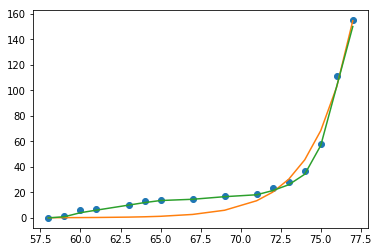

In [39]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [40]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 1374.81020789
Iteration 2, loss = 1373.95719448
Iteration 3, loss = 1373.09854737
Iteration 4, loss = 1372.23669719
Iteration 5, loss = 1371.37144233
Iteration 6, loss = 1370.49439654
Iteration 7, loss = 1369.61374433
Iteration 8, loss = 1368.72876024
Iteration 9, loss = 1367.83020755
Iteration 10, loss = 1366.92173807
Iteration 11, loss = 1366.00500599
Iteration 12, loss = 1365.06117989
Iteration 13, loss = 1364.11149122
Iteration 14, loss = 1363.12777986
Iteration 15, loss = 1362.11786461
Iteration 16, loss = 1361.06683821
Iteration 17, loss = 1359.97019536
Iteration 18, loss = 1358.86310274
Iteration 19, loss = 1357.74496647
Iteration 20, loss = 1356.61145791
Iteration 21, loss = 1355.46503222
Iteration 22, loss = 1354.30862762
Iteration 23, loss = 1353.14198736
Iteration 24, loss = 1351.96498098
Iteration 25, loss = 1350.77746021
Iteration 26, loss = 1349.58023520
Iteration 27, loss = 1348.37336980
Iteration 28, loss = 1347.14518862
Iteration 29, loss = 1345.900

Iteration 314, loss = 396.65258937
Iteration 315, loss = 395.92127215
Iteration 316, loss = 395.19109534
Iteration 317, loss = 394.46252867
Iteration 318, loss = 393.73598373
Iteration 319, loss = 393.01252973
Iteration 320, loss = 392.32614671
Iteration 321, loss = 391.62662062
Iteration 322, loss = 390.92399718
Iteration 323, loss = 390.24809882
Iteration 324, loss = 389.57401136
Iteration 325, loss = 388.90054543
Iteration 326, loss = 388.22810214
Iteration 327, loss = 387.55704368
Iteration 328, loss = 386.88769512
Iteration 329, loss = 386.22034631
Iteration 330, loss = 385.60600266
Iteration 331, loss = 384.94239565
Iteration 332, loss = 384.28173978
Iteration 333, loss = 383.65308265
Iteration 334, loss = 383.02414761
Iteration 335, loss = 382.39533230
Iteration 336, loss = 381.76700516
Iteration 337, loss = 381.14056669
Iteration 338, loss = 380.51672265
Iteration 339, loss = 379.89439875
Iteration 340, loss = 379.27356832
Iteration 341, loss = 378.65468980
Iteration 342, loss 

Iteration 619, loss = 275.56435202
Iteration 620, loss = 275.27234164
Iteration 621, loss = 274.98001842
Iteration 622, loss = 274.68744952
Iteration 623, loss = 274.39469730
Iteration 624, loss = 274.10181959
Iteration 625, loss = 273.80886984
Iteration 626, loss = 273.51589729
Iteration 627, loss = 273.22294718
Iteration 628, loss = 272.93006088
Iteration 629, loss = 272.63727610
Iteration 630, loss = 272.34462710
Iteration 631, loss = 272.05227846
Iteration 632, loss = 271.76012268
Iteration 633, loss = 271.46829203
Iteration 634, loss = 271.17667793
Iteration 635, loss = 270.89457897
Iteration 636, loss = 270.59855751
Iteration 637, loss = 270.31178524
Iteration 638, loss = 270.02497824
Iteration 639, loss = 269.73813617
Iteration 640, loss = 269.45126579
Iteration 641, loss = 269.16438028
Iteration 642, loss = 268.87696702
Iteration 643, loss = 268.58475387
Iteration 644, loss = 268.29215692
Iteration 645, loss = 267.99924667
Iteration 646, loss = 267.70654031
Iteration 647, loss 

Iteration 902, loss = 177.48990370
Iteration 903, loss = 177.06948333
Iteration 904, loss = 176.64883905
Iteration 905, loss = 176.22797723
Iteration 906, loss = 175.80690377
Iteration 907, loss = 175.38562421
Iteration 908, loss = 174.96414377
Iteration 909, loss = 174.54208631
Iteration 910, loss = 174.11690148
Iteration 911, loss = 173.69121019
Iteration 912, loss = 173.26504298
Iteration 913, loss = 172.83842771
Iteration 914, loss = 172.41138983
Iteration 915, loss = 171.98395267
Iteration 916, loss = 171.55613762
Iteration 917, loss = 171.12796435
Iteration 918, loss = 170.69945103
Iteration 919, loss = 170.27061443
Iteration 920, loss = 169.84147012
Iteration 921, loss = 169.41203258
Iteration 922, loss = 168.98231535
Iteration 923, loss = 168.55233111
Iteration 924, loss = 168.12209179
Iteration 925, loss = 167.69160867
Iteration 926, loss = 167.26089246
Iteration 927, loss = 166.82995334
Iteration 928, loss = 166.39880107
Iteration 929, loss = 165.96744502
Iteration 930, loss 

Iteration 1155, loss = 82.80597752
Iteration 1156, loss = 82.52148584
Iteration 1157, loss = 82.23643126
Iteration 1158, loss = 81.95110711
Iteration 1159, loss = 81.66656211
Iteration 1160, loss = 81.38294384
Iteration 1161, loss = 81.10240865
Iteration 1162, loss = 80.82413886
Iteration 1163, loss = 80.54399922
Iteration 1164, loss = 80.26481890
Iteration 1165, loss = 79.98855642
Iteration 1166, loss = 79.71223884
Iteration 1167, loss = 79.43608538
Iteration 1168, loss = 79.16051419
Iteration 1169, loss = 78.88814752
Iteration 1170, loss = 78.61515053
Iteration 1171, loss = 78.34095965
Iteration 1172, loss = 78.06978327
Iteration 1173, loss = 77.79874372
Iteration 1174, loss = 77.52794231
Iteration 1175, loss = 77.25902362
Iteration 1176, loss = 76.98899054
Iteration 1177, loss = 76.72201053
Iteration 1178, loss = 76.45512856
Iteration 1179, loss = 76.18842606
Iteration 1180, loss = 75.92198513
Iteration 1181, loss = 75.65588130
Iteration 1182, loss = 75.39018331
Iteration 1183, loss

Iteration 1403, loss = 32.30275665
Iteration 1404, loss = 32.17038279
Iteration 1405, loss = 32.03315804
Iteration 1406, loss = 31.90094871
Iteration 1407, loss = 31.76938623
Iteration 1408, loss = 31.63716093
Iteration 1409, loss = 31.50452857
Iteration 1410, loss = 31.37155875
Iteration 1411, loss = 31.23825982
Iteration 1412, loss = 31.10472796
Iteration 1413, loss = 30.98114762
Iteration 1414, loss = 30.85388322
Iteration 1415, loss = 30.72271246
Iteration 1416, loss = 30.58913914
Iteration 1417, loss = 30.46336471
Iteration 1418, loss = 30.33703550
Iteration 1419, loss = 30.21023278
Iteration 1420, loss = 30.08304769
Iteration 1421, loss = 29.95746911
Iteration 1422, loss = 29.83233877
Iteration 1423, loss = 29.70818794
Iteration 1424, loss = 29.58493324
Iteration 1425, loss = 29.46112773
Iteration 1426, loss = 29.33687172
Iteration 1427, loss = 29.21542359
Iteration 1428, loss = 29.09327464
Iteration 1429, loss = 28.97042254
Iteration 1430, loss = 28.84992415
Iteration 1431, loss

Iteration 1736, loss = 9.10252081
Iteration 1737, loss = 9.06621285
Iteration 1738, loss = 9.02997213
Iteration 1739, loss = 8.99383960
Iteration 1740, loss = 8.95780954
Iteration 1741, loss = 8.92184781
Iteration 1742, loss = 8.88598267
Iteration 1743, loss = 8.85020904
Iteration 1744, loss = 8.81450969
Iteration 1745, loss = 8.77892587
Iteration 1746, loss = 8.74342275
Iteration 1747, loss = 8.70798901
Iteration 1748, loss = 8.67266991
Iteration 1749, loss = 8.63744462
Iteration 1750, loss = 8.60229450
Iteration 1751, loss = 8.56722141
Iteration 1752, loss = 8.53227584
Iteration 1753, loss = 8.49741646
Iteration 1754, loss = 8.46262693
Iteration 1755, loss = 8.42790961
Iteration 1756, loss = 8.39334872
Iteration 1757, loss = 8.35886413
Iteration 1758, loss = 8.32445512
Iteration 1759, loss = 8.29012347
Iteration 1760, loss = 8.25587088
Iteration 1761, loss = 8.22171698
Iteration 1762, loss = 8.18769076
Iteration 1763, loss = 8.15373476
Iteration 1764, loss = 8.11985224
Iteration 1765

Iteration 2120, loss = 1.94455200
Iteration 2121, loss = 1.93895908
Iteration 2122, loss = 1.93324108
Iteration 2123, loss = 1.92759889
Iteration 2124, loss = 1.92197384
Iteration 2125, loss = 1.91637643
Iteration 2126, loss = 1.91072739
Iteration 2127, loss = 1.90520154
Iteration 2128, loss = 1.89964141
Iteration 2129, loss = 1.89413693
Iteration 2130, loss = 1.88857848
Iteration 2131, loss = 1.88309824
Iteration 2132, loss = 1.87790408
Iteration 2133, loss = 1.87270259
Iteration 2134, loss = 1.86748050
Iteration 2135, loss = 1.86226099
Iteration 2136, loss = 1.85701398
Iteration 2137, loss = 1.85174035
Iteration 2138, loss = 1.84669124
Iteration 2139, loss = 1.84161669
Iteration 2140, loss = 1.83672283
Iteration 2141, loss = 1.83165242
Iteration 2142, loss = 1.82655606
Iteration 2143, loss = 1.82157521
Iteration 2144, loss = 1.81663278
Iteration 2145, loss = 1.81167090
Iteration 2146, loss = 1.80669175
Iteration 2147, loss = 1.80181553
Iteration 2148, loss = 1.79704726
Iteration 2149

Iteration 2382, loss = 1.16801142
Iteration 2383, loss = 1.16661684
Iteration 2384, loss = 1.16518800
Iteration 2385, loss = 1.16377544
Iteration 2386, loss = 1.16239913
Iteration 2387, loss = 1.16102439
Iteration 2388, loss = 1.15965755
Iteration 2389, loss = 1.15832809
Iteration 2390, loss = 1.15694952
Iteration 2391, loss = 1.15559550
Iteration 2392, loss = 1.15428581
Iteration 2393, loss = 1.15293787
Iteration 2394, loss = 1.15159961
Iteration 2395, loss = 1.15023999
Iteration 2396, loss = 1.14894476
Iteration 2397, loss = 1.14763575
Iteration 2398, loss = 1.14634760
Iteration 2399, loss = 1.14496505
Iteration 2400, loss = 1.14369248
Iteration 2401, loss = 1.14239550
Iteration 2402, loss = 1.14107642
Iteration 2403, loss = 1.13976844
Iteration 2404, loss = 1.13852910
Iteration 2405, loss = 1.13720312
Iteration 2406, loss = 1.13594444
Iteration 2407, loss = 1.13468904
Iteration 2408, loss = 1.13344057
Iteration 2409, loss = 1.13215268
Iteration 2410, loss = 1.13092889
Iteration 2411

Iteration 2802, loss = 0.81687342
Iteration 2803, loss = 0.81642931
Iteration 2804, loss = 0.81598367
Iteration 2805, loss = 0.81558989
Iteration 2806, loss = 0.81519081
Iteration 2807, loss = 0.81475310
Iteration 2808, loss = 0.81432043
Iteration 2809, loss = 0.81387320
Iteration 2810, loss = 0.81342556
Iteration 2811, loss = 0.81299350
Iteration 2812, loss = 0.81258666
Iteration 2813, loss = 0.81215681
Iteration 2814, loss = 0.81175878
Iteration 2815, loss = 0.81132068
Iteration 2816, loss = 0.81088026
Iteration 2817, loss = 0.81047490
Iteration 2818, loss = 0.81003505
Iteration 2819, loss = 0.80961667
Iteration 2820, loss = 0.80923913
Iteration 2821, loss = 0.80879349
Iteration 2822, loss = 0.80838049
Iteration 2823, loss = 0.80797582
Iteration 2824, loss = 0.80753720
Iteration 2825, loss = 0.80714478
Iteration 2826, loss = 0.80674985
Iteration 2827, loss = 0.80633686
Iteration 2828, loss = 0.80593723
Iteration 2829, loss = 0.80550942
Iteration 2830, loss = 0.80509655
Iteration 2831

Iteration 3218, loss = 0.68557751
Iteration 3219, loss = 0.68536287
Iteration 3220, loss = 0.68513397
Iteration 3221, loss = 0.68489276
Iteration 3222, loss = 0.68469822
Iteration 3223, loss = 0.68448850
Iteration 3224, loss = 0.68424804
Iteration 3225, loss = 0.68401826
Iteration 3226, loss = 0.68381596
Iteration 3227, loss = 0.68359818
Iteration 3228, loss = 0.68336723
Iteration 3229, loss = 0.68314818
Iteration 3230, loss = 0.68293326
Iteration 3231, loss = 0.68269906
Iteration 3232, loss = 0.68249381
Iteration 3233, loss = 0.68226909
Iteration 3234, loss = 0.68204160
Iteration 3235, loss = 0.68183665
Iteration 3236, loss = 0.68161589
Iteration 3237, loss = 0.68140075
Iteration 3238, loss = 0.68118812
Iteration 3239, loss = 0.68096859
Iteration 3240, loss = 0.68076179
Iteration 3241, loss = 0.68054519
Iteration 3242, loss = 0.68032991
Iteration 3243, loss = 0.68012647
Iteration 3244, loss = 0.67990471
Iteration 3245, loss = 0.67970709
Iteration 3246, loss = 0.67949641
Iteration 3247

Iteration 3525, loss = 0.63325618
Iteration 3526, loss = 0.63313285
Iteration 3527, loss = 0.63299833
Iteration 3528, loss = 0.63287756
Iteration 3529, loss = 0.63274909
Iteration 3530, loss = 0.63262819
Iteration 3531, loss = 0.63250705
Iteration 3532, loss = 0.63238141
Iteration 3533, loss = 0.63226602
Iteration 3534, loss = 0.63214593
Iteration 3535, loss = 0.63201848
Iteration 3536, loss = 0.63190485
Iteration 3537, loss = 0.63178827
Iteration 3538, loss = 0.63166282
Iteration 3539, loss = 0.63153232
Iteration 3540, loss = 0.63141425
Iteration 3541, loss = 0.63129149
Iteration 3542, loss = 0.63117022
Iteration 3543, loss = 0.63105277
Iteration 3544, loss = 0.63093588
Iteration 3545, loss = 0.63082095
Iteration 3546, loss = 0.63070639
Iteration 3547, loss = 0.63058259
Iteration 3548, loss = 0.63046519
Iteration 3549, loss = 0.63035137
Iteration 3550, loss = 0.63022978
Iteration 3551, loss = 0.63010497
Iteration 3552, loss = 0.62998814
Iteration 3553, loss = 0.62987209
Iteration 3554

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  0.41137997,   2.43040698,   4.449434  ,   6.46846101,
        10.50651505,  12.52554206,  13.49000449,  15.41282045,
        17.31482333,  19.1776025 ,  23.30710783,  27.43661316,
        37.07972453,  59.44562937, 107.99776496, 156.54990055])

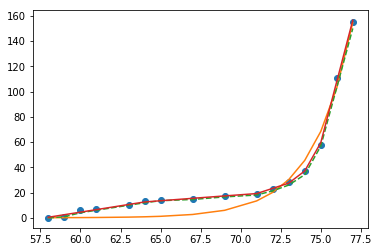

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [43]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([20355.35552838])